In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm # to track the progress
from torch.utils.data import DataLoader
from torchvision import datasets, transforms as T # image specific torch functions bc we will work with the MNIST dataset
from torchvision.utils import make_grid


In [14]:
# configurations
device = 'cuda'

batch_size = 128
noise_dim = 64
epochs = 25

#adam
lr = 0.0001
beta_1 =0.5
beta_2 = 0.99


Total number of train images in train set  60000
Total number of images in val set  10000


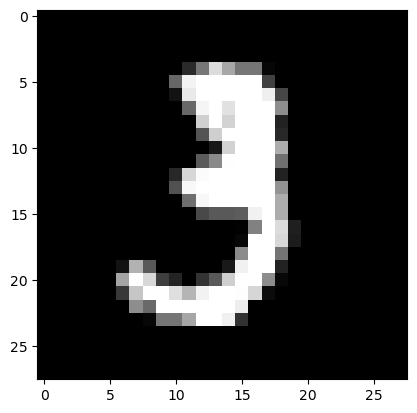

In [20]:
# Get the data

train_augs = T.Compose([ # Compose allows us to apply all these operations to samples!
    T.RandomRotation((-20, +20)), # apply random rotation between -20 and +20 degrees to image
    T.ToTensor() # convert image to tensor
])

train_data = datasets.MNIST('MNIST/', train = True, download = True, transform = train_augs) # the transformations such as data augmentation are performed dynamically during training
print("Total number of train images in train set ", len(train_data))

val_data = datasets.MNIST('MNIST/', train = False, download = True, transform = train_augs) # the transformations such as data augmentation are performed dynamically during training
print("Total number of images in val set ", len(val_data))


image, label = train_data[10]
plt.imshow(image.squeeze(), cmap='gray')


In [21]:
# Build dataloader

train_dataloader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
print("Total # of batches in train set ", len(train_dataloader))

val_dataloader = DataLoader(val_data, batch_size = batch_size, shuffle = True)
print("Total # of batches in validation set ", len(val_dataloader))

dataiter = iter(train_dataloader)

images, _ = next(dataiter)

print("Shape of image batch ", images.shape)



Total # of batches in train set  469
Total # of batches in validation set  79
Shape of image batch  torch.Size([128, 1, 28, 28])


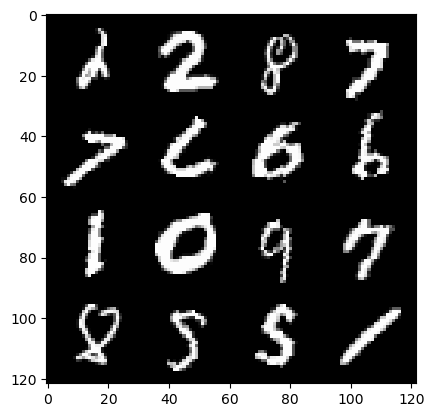

In [17]:
# 'show_tensor_images' : function is used to plot some of images from the batch

def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu() # convert from tensor to image
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

show_tensor_images(images)

In [6]:
from torch import nn
from torchsummary import summary

# Define Network Architectures

# Discriminator Network

def discriminator_block(input_dim, output_dim, kernel_dim, stride_dim):
  return nn.Sequential(
      nn.Conv2d(input_dim, output_dim, kernel_dim, stride_dim),
      nn.BatchNorm2d(output_dim),
      nn.LeakyReLU(0.2)
  )

class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.block_1 = discriminator_block(1, 16, (3, 3), 2)
    self.block_2 = discriminator_block(16, 32, (5,5), 2)
    self.block_3 = discriminator_block(32, 64, (5, 5), 2)

    self.flatten = nn.Flatten()
    self.linear = nn.Linear(64, 1)

  def forward(self, x):
    x = self.block_1(x)
    x = self.block_2(x)
    x = self.block_3(x)
    x = self.flatten(x)
    return self.linear(x)

# Generator Network

def generator_block(input_dim, output_dim, kernel_dim, stride_dim, final=False):
  if final:
    return nn.Sequential(
        nn.ConvTranspose2d(input_dim, output_dim, kernel_dim, stride_dim),
        nn.Tanh()
  )

  return nn.Sequential(
      nn.ConvTranspose2d(input_dim, output_dim, kernel_dim, stride_dim),
      nn.BatchNorm2d(output_dim),
      nn.ReLU()
)

class Generator(nn.Module):

  def __init__(self, noise_dim):
    super(Generator, self).__init__()

    self.noise_dim = noise_dim
    self.block_1 = generator_block(noise_dim, 256, (3,3), 2, final=False)
    self.block_2 = generator_block(256, 128, (4,4), 1, final=False)
    self.block_3 = generator_block(128, 64, (3,3), 2, final=False)
    self.block_4 = generator_block(64, 1, (4,4), 2, final=True)

  def forward(self, r_noise_vec):

    x = r_noise_vec.view(-1, self.noise_dim, 1, 1)
    x = self.block_1(x)
    x = self.block_2(x)
    x = self.block_3(x)

    return self.block_4(x)

# Replace Random initialized weights to Normal weights
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)



In [7]:
# Create Discriminator 

print("Discriminator Netowrk")

D = Discriminator() # get architecutre
D.to(device)
summary(D, (1, 28, 28))

# Next step is absolutely crucial in GAN due tot he nature of the adversarial framework where generator and discriminator are trained simulatneously.
# Their performance depends on maintaining a balanced process and initialization effects can influence the convergence.

D = D.apply(weights_init) # use normal weights instead of randomly initialized!

D_optimizer = torch.optim.Adam(D.parameters(), lr = lr, betas = (beta_1, beta_2)) # set up the optimizer


Discriminator Netowrk
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 13, 13]             160
       BatchNorm2d-2           [-1, 16, 13, 13]              32
         LeakyReLU-3           [-1, 16, 13, 13]               0
            Conv2d-4             [-1, 32, 5, 5]          12,832
       BatchNorm2d-5             [-1, 32, 5, 5]              64
         LeakyReLU-6             [-1, 32, 5, 5]               0
            Conv2d-7             [-1, 64, 1, 1]          51,264
       BatchNorm2d-8             [-1, 64, 1, 1]             128
         LeakyReLU-9             [-1, 64, 1, 1]               0
          Flatten-10                   [-1, 64]               0
           Linear-11                    [-1, 1]              65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0
----------------------------------------------------------------
Input size

In [8]:


# Create Generator 

G = Generator(noise_dim) # architecture
G.to(device)
summary(G, input_size = (1, noise_dim))

G = G.apply(weights_init) # use normalised weights instead of randomly initialised (crucial for learning)

G_optimizer = torch.optim.Adam(G.parameters(), lr = lr, betas = (beta_1, beta_2)) # set up the optimizer


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 256, 3, 3]         147,712
       BatchNorm2d-2            [-1, 256, 3, 3]             512
              ReLU-3            [-1, 256, 3, 3]               0
   ConvTranspose2d-4            [-1, 128, 6, 6]         524,416
       BatchNorm2d-5            [-1, 128, 6, 6]             256
              ReLU-6            [-1, 128, 6, 6]               0
   ConvTranspose2d-7           [-1, 64, 13, 13]          73,792
       BatchNorm2d-8           [-1, 64, 13, 13]             128
              ReLU-9           [-1, 64, 13, 13]               0
  ConvTranspose2d-10            [-1, 1, 28, 28]           1,025
             Tanh-11            [-1, 1, 28, 28]               0
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

In [9]:
# Create loss functions

def loss_ones(pred): # classifies truth, used for real in the discriminator and for fake predictions in the generator (hence why generator tries to maximise its loss function).
  criterion = nn.BCEWithLogitsLoss()
  labels = torch.ones_like(pred).to(device)
  loss = criterion(pred, labels)

  return loss

def loss_zeros(pred): # classifies false i.e. for fakes in the discriminator
  criterion = nn.BCEWithLogitsLoss()
  labels = torch.zeros_like(pred).to(device)
  loss = criterion(pred, labels)

  return loss


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.91204756..0.9997589].


Epoch: 0 | D_loss: 0.5282242312105988 | G_loss: 0.9004435039786641
fake image


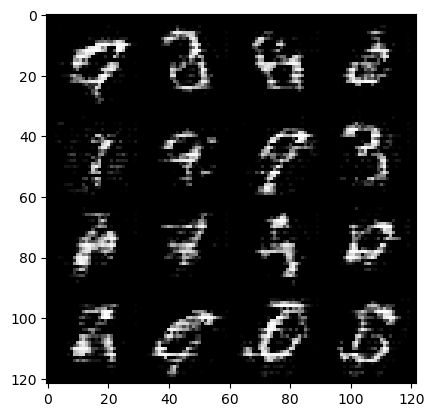

Epoch: 1 | D_loss: 0.4936418220051316 | G_loss: 0.9726794569222912
Epoch: 2 | D_loss: 0.4902689913823915 | G_loss: 1.0023896199807938
Epoch: 3 | D_loss: 0.4965738036485115 | G_loss: 1.0158075664851711
Epoch: 4 | D_loss: 0.5100773356235357 | G_loss: 1.014224440939645


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.66934..1.0].


Epoch: 5 | D_loss: 0.5187804901015276 | G_loss: 1.0102751876499607
fake image


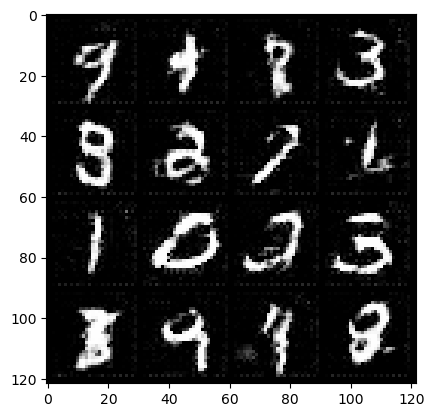

Epoch: 6 | D_loss: 0.5306083305176895 | G_loss: 1.0034658771588096
Epoch: 7 | D_loss: 0.5368873908448575 | G_loss: 0.9983538733616567
Epoch: 8 | D_loss: 0.5492808671394137 | G_loss: 0.9811847634406995
Epoch: 9 | D_loss: 0.5559861037268568 | G_loss: 0.9787795661863233


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5708906..1.0].


Epoch: 10 | D_loss: 0.561289749801286 | G_loss: 0.9781255821175159
fake image


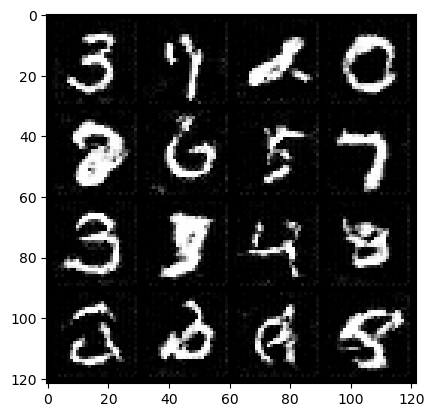

Epoch: 11 | D_loss: 0.5677484276452298 | G_loss: 0.9692997838388374
Epoch: 12 | D_loss: 0.5730091075399029 | G_loss: 0.963581648970972
Epoch: 13 | D_loss: 0.5736204789899814 | G_loss: 0.9593834312739911
Epoch: 14 | D_loss: 0.5795483699739615 | G_loss: 0.9532266806946126


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.2513946..1.0].


Epoch: 15 | D_loss: 0.582209276110887 | G_loss: 0.9474890730274257
fake image


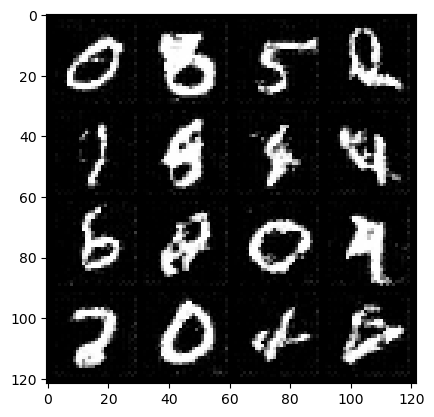

Epoch: 16 | D_loss: 0.5865576077880127 | G_loss: 0.9422370406356193
Epoch: 17 | D_loss: 0.5903187235281158 | G_loss: 0.9404173418402926
Epoch: 18 | D_loss: 0.5920651059415041 | G_loss: 0.9383652297926864
Epoch: 19 | D_loss: 0.593629209471664 | G_loss: 0.9331495266225038


In [12]:
# Training 

for i in range(epochs):

    total_d_loss = 0.0
    total_g_loss = 0.0

    
    for real_images, _ in train_dataloader: # tqdm(train_dataloader) tracks the loop progression

        # Send real image to GPU
        real_images = real_images.to(device)
        # generate fake image and sent to GPU
        noise = torch.randn(batch_size, noise_dim, device = device)
        fake_images = G(noise)
    
        # Make sure both optimizers have a gradient of zero
        D_optimizer.zero_grad()
        G_optimizer.zero_grad() 
    
        # Discriminator
    
        # Predictions
        pred_real = D(real_images)
        pred_fake = D(fake_images)  # Detach to prevent gradients flowing to G
    
        # Calculate real and fake loss
        d_real_loss = loss_ones(pred_real)
        d_fake_loss = loss_zeros(pred_fake)
    
        # add real and fake image loss discriminant components
        d_loss = (d_real_loss + d_fake_loss)/2
        total_d_loss += d_loss.item()
    
        # back-prop the loss funciton and do one step on the optimizer
        d_loss.backward() # computes gradient
        D_optimizer.step() # update weights
    
        ### Generator
    
        # The graph space has been used so you need to generate the pred_fakes again..
        noise = torch.randn(batch_size, noise_dim, device = device) # generate random noise again, or thigns will not work ;)
        fake_images = G(noise)
        pred_fake = D(fake_images)
    
        g_loss = loss_ones(pred_fake) # pred_fakes
        total_g_loss += g_loss.item()
    
        g_loss.backward() # computes gradient
        G_optimizer.step()  # update weights
    
      avg_d_loss = total_d_loss/len(train_dataloader)
      avg_g_loss = total_g_loss/len(train_dataloader)
    
      print("Epoch: {} | D_loss: {} | G_loss: {}".format(i, avg_d_loss, avg_g_loss))
      if i % 5 == 0:
          print("fake image")
          show_tensor_images(fake_images) # see how the fake images improve during training!
          #show_tensor_images(real_images)
    
    #for real_images, _ in val_dataloader: # tqdm(train_dataloader) tracks the loop progression
        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.315806..1.0].


Generated image


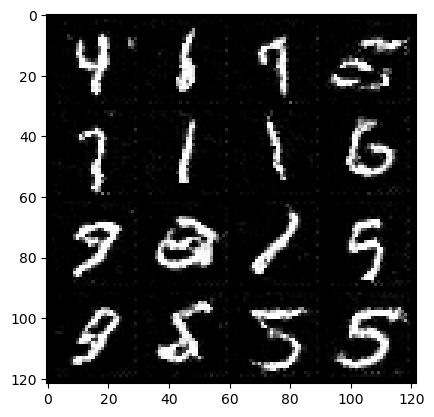

Real image


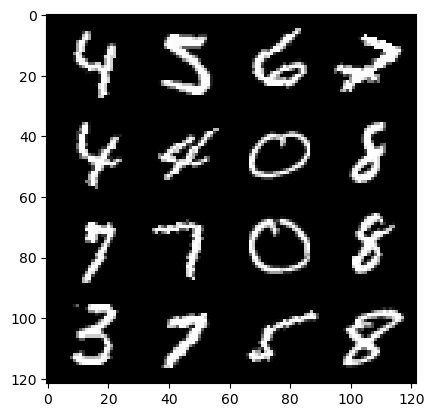

In [19]:
# Once trained, the generator can be used to generate new images!

noise = torch.randn(batch_size, noise_dim, device = device)
generated_image = G(noise)

print("Generated image")
show_tensor_images(generated_image)
print("Real image")
show_tensor_images(real_images)